## **0. 루브릭**

| 평가문항 | 상세기준 |
| --- | --- |
| 1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다. |
| 2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다. |
| 3. Ablation Study 결과가 바른 포맷으로 제출되었는가? | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. |


## **1. ResNet vs Plain 학습 결과 확인하기**

### **1) 필요한 라이브러리와 설정 값 불러오기**

In [1]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [2]:
# 하이퍼파라미터 불러오기

# 배치 크기 설정, 현재 32로 설정되어 있음
BATCH_SIZE = 32
# 에포크 수 설정, 현재 10로 설정되어 있음
EPOCHS = 15
# 학습률 설정, 현재 0.1로 설정되어 있음
LR = 0.1
# 옵티마이저 학습률 설정하기
OPT_DECAY = 0.001
# 모멘텀 설정하기
MOMENTUM = 0.9
# L2 정규화 설정하기
L2_WEIGHT_DECAY = 1e-4
# 배치 정규화 감쇠 설정하기
BATCH_NORM_DECAY = 0.9
# 배치 정규화 epsilon 설정하기
BATCH_NORM_EPSILON = 1e-5

# 활성화 함수 설정하기
ACTIVATION = 'sigmoid'
# 클래스 수 설정하기
NUM_CLASSES = 1  # 클래스 수 설정

### **2) 데이터셋 불러오기 및 전처리하기**

In [3]:
# 데이터셋을 로드하고 학습 및 테스트 세트로 분할
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
# 데이터셋의 feature 정보 확인하기
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [5]:
# 훈련 데이터 개수 확인하기
print(tf.data.experimental.cardinality(ds_train))

tf.Tensor(18610, shape=(), dtype=int64)


In [6]:
# 테스트 데이터 개수 확인하기
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
# 클래스 개수 확인하기
ds_info.features["label"].num_classes

2

In [8]:
# 클래스 이름 확인하기
ds_info.features["label"].names

['cat', 'dog']

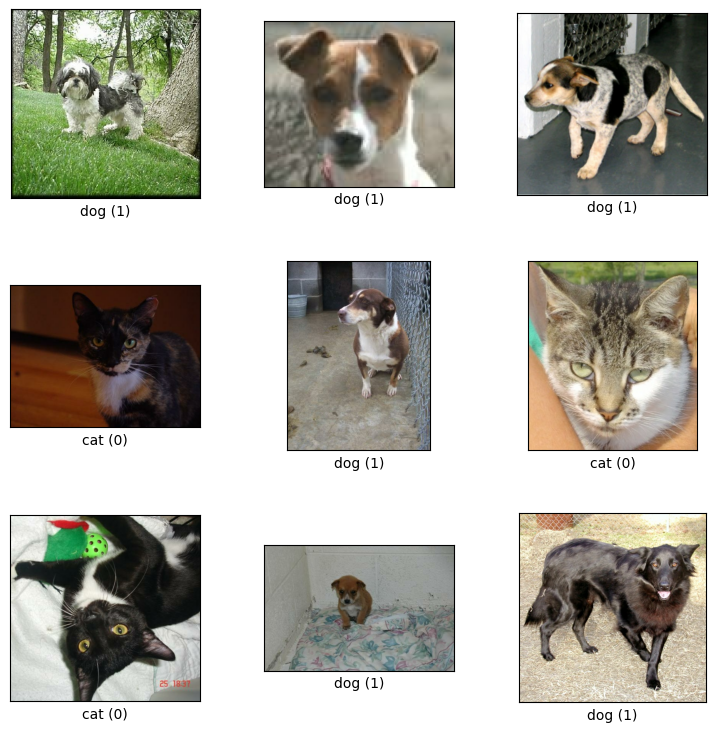

In [9]:
# 훈련 데이터셋에서 예시 이미지 표시하기
fig = tfds.show_examples(ds_train, ds_info)

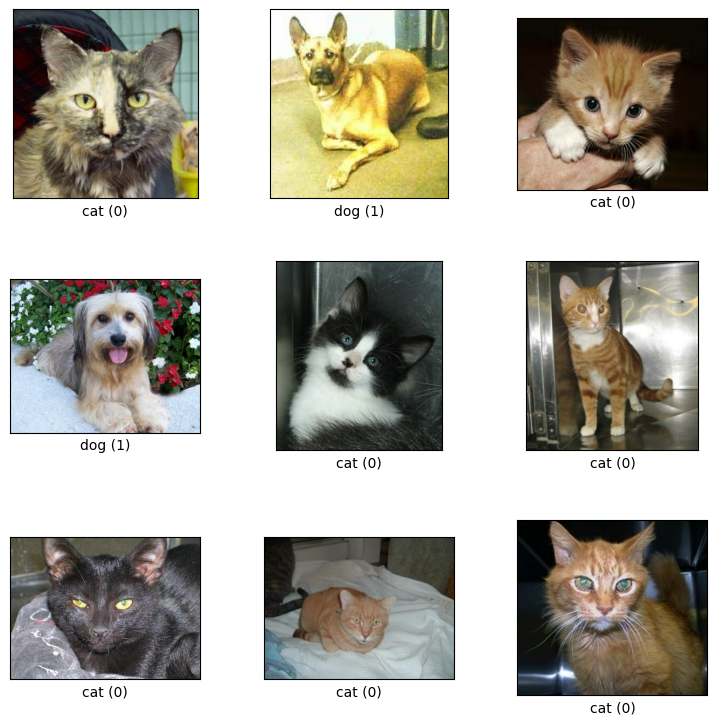

In [10]:
# 테스트 데이터셋에서 예시 이미지 표시하기
fig = tfds.show_examples(ds_test, ds_info)

In [11]:
# 이미지 정규화 및 크기 조정 함수 정의하기
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [12]:
# 데이터셋에 정규화 및 배치 적용하기
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
# 훈련, 테스트 데이터셋에 적용하기
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### **3) ResNet 블록 및 모델 정의하기**

In [14]:
# ResNet 기본 블록 정의하기
def basic_block(input_layer, channel, strides=1):
    x = keras.layers.Conv2D(
        filters=channel,                # 출력 채널 수
        kernel_size=(3,3),              # 필터 크기
        kernel_initializer='he_normal', # He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
        padding='same',                 # 패딩
        strides=strides,                # 스트라이드
        use_bias=False,                 # 바이어스 사용 안 함
    )(input_layer)

    # 배치 정규화와 활성화 함수
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 두 번째 3x3 합성곱 층
    x = keras.layers.Conv2D(
        filters=channel,                # 출력 채널 수
        kernel_size=(3,3),              # 필터 크기
        kernel_initializer='he_normal', # He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
        padding='same',                 # 패딩
        strides=1,                      # 스트라이드
        use_bias=False,                 # 바이어스 사용 안 함
    )(x)

    # 배치 정규화하기
    x = keras.layers.BatchNormalization()(x)

    # 입력과 출력의 차원이 다르면 shortcut 경로에 1x1 합성곱 층 추가하기
    if strides != 1 or input_layer.shape[-1] != channel:
        shortcut = keras.layers.Conv2D(
            filters=channel,            # 출력 채널 수
            kernel_size=(1,1),          # 필터 크기
            kernel_initializer='he_normal', # He 초기화
            kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
            padding='same',             # 패딩
            strides=strides,            # 스트라이드
            use_bias=False,             # 바이어스 사용 안 함
        )(input_layer)
        shortcut = keras.layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_layer

    # 합성곱 층 출력과 shortcut 경로의 출력을 더하기
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

In [15]:
# ResNet 병목 블록 정의하기
def bottleneck_block(input_layer, channel, strides=1):
    # 첫 번째 1x1 합성곱 층
    x = keras.layers.Conv2D(
        filters=channel,                # 출력 채널 수
        kernel_size=(1,1),              # 필터 크기
        kernel_initializer='he_normal', # He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
        padding='same',                 # 패딩
        use_bias=False,                 # 바이어스 사용 안 함
    )(input_layer)

    # 배치 정규화와 활성화 함수
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 두 번째 3x3 합성곱 층
    x = keras.layers.Conv2D(
        filters=channel,                # 출력 채널 수
        kernel_size=(3,3),              # 필터 크기
        kernel_initializer='he_normal', # He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
        padding='same',                 # 패딩
        strides=strides,                # 스트라이드
        use_bias=False,                 # 바이어스 사용 안 함
    )(x)

    # 배치 정규화와 활성화 함수
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 세 번째 1x1 합성곱 층
    x = keras.layers.Conv2D(
        filters=channel * 4,            # 출력 채널 수 (4배로 증가)
        kernel_size=(1,1),              # 필터 크기
        kernel_initializer='he_normal', # He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
        padding='same',                 # 패딩
        use_bias=False,                 # 바이어스 사용 안 함
    )(x)

    # 배치 정규화
    x = keras.layers.BatchNormalization()(x)

    # 입력과 출력의 차원이 다르면 shortcut 경로에 1x1 합성곱 층 추가하기
    if strides != 1 or input_layer.shape[-1] != channel * 4:
        shortcut = keras.layers.Conv2D(
            filters=channel * 4,        # 출력 채널 수 (4배로 증가)
            kernel_size=(1,1),          # 필터 크기
            kernel_initializer='he_normal', # He 초기화
            kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
            padding='same',             # 패딩
            strides=strides,            # 스트라이드
            use_bias=False,             # 바이어스 사용 안 함
        )(input_layer)
        shortcut = keras.layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_layer

    # 합성곱 층 출력과 shortcut 경로의 출력을 더함
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

In [16]:
# ResNet 모델 빌드 함수 정의하기
def build_resnet(input_shape, num_classes, block_type, repetitions):
    # 입력 레이어 정의하기
    input_layer = keras.layers.Input(shape=input_shape)

    # 첫 번째 7x7 합성곱 층
    x = keras.layers.Conv2D(
        filters=64,                    # 출력 채널 수
        kernel_size=(7,7),             # 필터 크기
        kernel_initializer='he_normal',# He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
        padding='same',                # 패딩
        strides=2,                     # 스트라이드
        use_bias=False,                # 바이어스 사용 안 함
    )(input_layer)


    # 배치 정규화와 활성화 함수
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 최대 풀링 층
    x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    # 반복 블록 추가
    for i, r in enumerate(repetitions):
        for j in range(r):
            if block_type == 'basic':
                if j == 0 and i > 0:
                    # 첫 블록에 스트라이드 적용하기
                    x = basic_block(x, 64 * (2 ** i), strides=2)
                else:
                    x = basic_block(x, 64 * (2 ** i))
            elif block_type == 'bottleneck':
                if j == 0 and i > 0:
                    # 첫 블록에 스트라이드 적용하기
                    x = bottleneck_block(x, 64 * (2 ** i), strides=2)
                else:
                    x = bottleneck_block(x, 64 * (2 ** i))

    # 전역 평균 풀링 층
    x = keras.layers.GlobalAveragePooling2D()(x)

    # 출력 밀집 층
    x = keras.layers.Dense(
        units=num_classes,             # 출력 클래스 수
        activation=ACTIVATION,         # 출력 활성화 함수
        kernel_initializer='he_normal',# He 초기화
        kernel_regularizer=keras.regularizers.l2(L2_WEIGHT_DECAY), # L2 가중치 감소
    )(x)

    # 모델 정의하기
    model = keras.Model(inputs=input_layer, outputs=x)

    return model

### **4) 모델 생성 및 요약하기**

In [17]:
# ResNet34 모델 생성하기
resnet_34 = build_resnet(
    input_shape=(224,224,3),
    num_classes=NUM_CLASSES,
    block_type='basic',
    repetitions=[3, 4, 6, 3]
)

In [18]:
# ResNet34 모델 요약하기
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [19]:
# ResNet50 모델 생성하기
resnet_50 = build_resnet(
    input_shape=(224,224,3),
    num_classes=NUM_CLASSES,
    block_type='bottleneck',
    repetitions=[3, 4, 6, 3]
)

In [20]:
# ResNet50 모델 요약하기
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 112, 112, 64)         9408      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 112, 112, 64)         256       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_33 (ReLU)             (None, 112, 112, 64)         0         ['batch_normalization_36

In [21]:
# Plain34 모델 생성하기
plain_34 = build_resnet(
    input_shape=(224,224,3),
    num_classes=NUM_CLASSES,
    block_type='basic',
    repetitions=[3, 4, 6, 3]
)

In [22]:
# Plain34 모델 요약하기
plain_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_89 (Conv2D)          (None, 112, 112, 64)         9408      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_89 (Ba  (None, 112, 112, 64)         256       ['conv2d_89[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_82 (ReLU)             (None, 112, 112, 64)         0         ['batch_normalization_89

In [23]:
# Plain50 모델 생성하기
plain_50 = build_resnet(
    input_shape=(224,224,3),
    num_classes=NUM_CLASSES,
    block_type='bottleneck',
    repetitions=[3, 4, 6, 3]
)

In [24]:
# Plain50 모델 요약하기
plain_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_125 (Conv2D)         (None, 112, 112, 64)         9408      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_125 (B  (None, 112, 112, 64)         256       ['conv2d_125[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_115 (ReLU)            (None, 112, 112, 64)         0         ['batch_normalization_12

### **5) 모델 컴파일 및 학습하기**

In [33]:
# 학습률 스케줄 정의하기
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=100000,
    decay_rate=OPT_DECAY,
    staircase=True)

In [34]:
# 옵티마이저 정의하기
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule,
                                           momentum=MOMENTUM)

In [27]:
# ResNet34 모델 컴파일하기
resnet_34.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [28]:
# ResNet34 모델 학습 기록하기
history_resnet_34 = resnet_34.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test
)

Epoch 1/15
582/582 [==============================] - 135s 197ms/step - loss: 2.4316 - accuracy: 0.5715 - val_loss: 2.4094 - val_accuracy: 0.5095
Epoch 2/15
582/582 [==============================] - 117s 192ms/step - loss: 1.9577 - accuracy: 0.6245 - val_loss: 2.0419 - val_accuracy: 0.5456
Epoch 3/15
582/582 [==============================] - 117s 192ms/step - loss: 1.6473 - accuracy: 0.6749 - val_loss: 1.7193 - val_accuracy: 0.5991
Epoch 4/15
582/582 [==============================] - 117s 193ms/step - loss: 1.3913 - accuracy: 0.7206 - val_loss: 2.1078 - val_accuracy: 0.5518
Epoch 5/15
582/582 [==============================] - 117s 193ms/step - loss: 1.1761 - accuracy: 0.7584 - val_loss: 1.3223 - val_accuracy: 0.6513
Epoch 6/15
582/582 [==============================] - 117s 192ms/step - loss: 1.0189 - accuracy: 0.7788 - val_loss: 1.0215 - val_accuracy: 0.7436
Epoch 7/15
582/582 [==============================] - 117s 193ms/step - loss: 0.8594 - accuracy: 0.8206 - val_loss: 1.6062 -

In [35]:
# ResNet50 모델 컴파일하기
resnet_50.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [36]:
# ResNet50 모델 학습 기록하기
history_resnet_50 = resnet_50.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test
)

Epoch 1/15
582/582 [==============================] - 227s 364ms/step - loss: 6.7012 - accuracy: 0.5434 - val_loss: 5.7497 - val_accuracy: 0.5778
Epoch 2/15
582/582 [==============================] - 210s 353ms/step - loss: 5.2081 - accuracy: 0.5679 - val_loss: 4.7157 - val_accuracy: 0.5353
Epoch 3/15
582/582 [==============================] - 210s 353ms/step - loss: 4.2573 - accuracy: 0.5922 - val_loss: 3.8663 - val_accuracy: 0.5890
Epoch 4/15
582/582 [==============================] - 210s 354ms/step - loss: 3.4875 - accuracy: 0.6414 - val_loss: 3.1727 - val_accuracy: 0.6365
Epoch 5/15
582/582 [==============================] - 210s 354ms/step - loss: 2.8802 - accuracy: 0.6659 - val_loss: 2.7828 - val_accuracy: 0.5626
Epoch 6/15
582/582 [==============================] - 210s 354ms/step - loss: 2.3891 - accuracy: 0.6875 - val_loss: 2.2291 - val_accuracy: 0.6827
Epoch 7/15
582/582 [==============================] - 211s 354ms/step - loss: 2.0052 - accuracy: 0.7088 - val_loss: 1.9000 -

In [37]:
# Plain34 모델 컴파일하기
plain_34.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Plain34 모델 학습 기록하기
history_plain_34 = plain_34.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test
)

Epoch 1/15
582/582 [==============================] - 121s 193ms/step - loss: 2.6231 - accuracy: 0.5616 - val_loss: 2.3076 - val_accuracy: 0.5123
Epoch 2/15
582/582 [==============================] - 116s 192ms/step - loss: 2.0619 - accuracy: 0.6232 - val_loss: 2.1347 - val_accuracy: 0.5232
Epoch 3/15
582/582 [==============================] - 116s 192ms/step - loss: 1.7250 - accuracy: 0.6778 - val_loss: 1.6909 - val_accuracy: 0.6116
Epoch 4/15
582/582 [==============================] - 116s 192ms/step - loss: 1.4613 - accuracy: 0.7135 - val_loss: 1.3745 - val_accuracy: 0.7132
Epoch 5/15
582/582 [==============================] - 116s 192ms/step - loss: 1.2533 - accuracy: 0.7396 - val_loss: 1.8777 - val_accuracy: 0.5406
Epoch 6/15
582/582 [==============================] - 116s 192ms/step - loss: 1.0740 - accuracy: 0.7658 - val_loss: 1.0154 - val_accuracy: 0.7713
Epoch 7/15
582/582 [==============================] - 116s 192ms/step - loss: 0.9231 - accuracy: 0.7949 - val_loss: 1.0221 -

In [44]:
# Plain50 모델 컴파일하기
plain_50.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [50]:
# Plain50 모델 학습 기록하기
history_plain_50 = plain_50.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test
)

Epoch 1/15
582/582 [==============================] - 213s 353ms/step - loss: 13.9008 - accuracy: 0.5027 - val_loss: 12.3043 - val_accuracy: 0.5099
Epoch 2/15
582/582 [==============================] - 208s 351ms/step - loss: 11.0459 - accuracy: 0.5266 - val_loss: 9.9239 - val_accuracy: 0.5284
Epoch 3/15
582/582 [==============================] - 208s 351ms/step - loss: 8.8830 - accuracy: 0.5525 - val_loss: 7.9656 - val_accuracy: 0.5544
Epoch 4/15
582/582 [==============================] - 209s 351ms/step - loss: 7.1604 - accuracy: 0.5834 - val_loss: 6.4415 - val_accuracy: 0.5636
Epoch 5/15
582/582 [==============================] - 209s 351ms/step - loss: 5.7898 - accuracy: 0.6173 - val_loss: 5.2176 - val_accuracy: 0.5926
Epoch 6/15
582/582 [==============================] - 209s 351ms/step - loss: 4.7002 - accuracy: 0.6545 - val_loss: 4.2712 - val_accuracy: 0.6182
Epoch 7/15
582/582 [==============================] - 209s 352ms/step - loss: 3.8246 - accuracy: 0.6871 - val_loss: 3.512

### **6) 학습 결과 시각화하기**

In [52]:
# history 객체에서 학습 및 검증 정확도와 손실 값을 시각화하기
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # 정확도 시각화하기
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 시각화하기
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

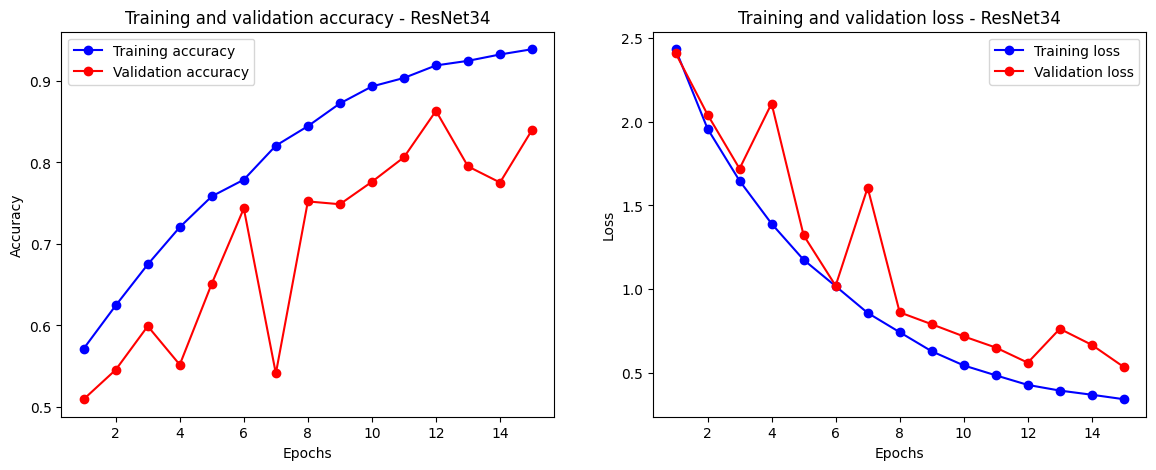

In [49]:
# ResNet34 학습 히스토리 시각화하기
plot_history(history_resnet_34, 'ResNet34')

**왼쪽 그래프: 학습 및 검증 정확도**
* **파란색 선 (학습 정확도)** : 에포크가 진행됨에 따라 정확도가 꾸준히 증가하며, 15번째 에포크가 끝날 때쯤 0.95에 가까워집니다.
* **빨간색 선 (검증 정확도)** : 초기에는 증가하지만, 상당한 변동을 보이며 눈에 띄는 하락과 상승이 반복되고, 15번째 에포크가 끝날 때쯤 약 0.7에 안정화됩니다.

**오른쪽 그래프: 학습 및 검증 손실**
* **파란색 선 (학습 손실)** : 에포크가 진행됨에 따라 손실이 꾸준히 감소하며, 15번째 에포크가 끝날 때쯤 매우 낮은 값에 도달합니다.
* **빨간색 선 (검증 손실)** : 또한 감소 추세를 보이지만, 상당한 변동이 있습니다. 초기에는 높게 시작하여 떨어지지만, 여러 지점에서 급격히 상승하는 불안정성을 보이며, 전체적으로는 감소하는 경향을 보입니다.

**해석**
* **학습 성능**
  * 학습 정확도는 꾸준히 증가하고 학습 손실은 지속적으로 감소하여 모델이 학습 데이터로부터 효과적으로 학습하고 있음을 나타냅니다.
* **검증 성능**
  * 검증 정확도와 손실은 상당한 변동을 보여, 검증 세트에서 성능이 일정하지 않음을 나타냅니다.
  * 최종 검증 정확도는 약 0.7로 안정화되며, 학습 정확도보다 낮아 과적합(overfitting)의 가능성을 시사합니다.
  * 검증 손실의 불안정한 패턴도 모델이 학습 데이터에 과적합하여 보이지 않는 데이터에 대해 일반화(generalization)하는 데 어려움을 겪고 있음을 나타냅니다.

**결론**
* ResNet34 모델은 학습 세트에서는 좋은 학습 성능을 보여주지만, 검증 세트에서는 일반화에 어려움을 겪고 있습니다.

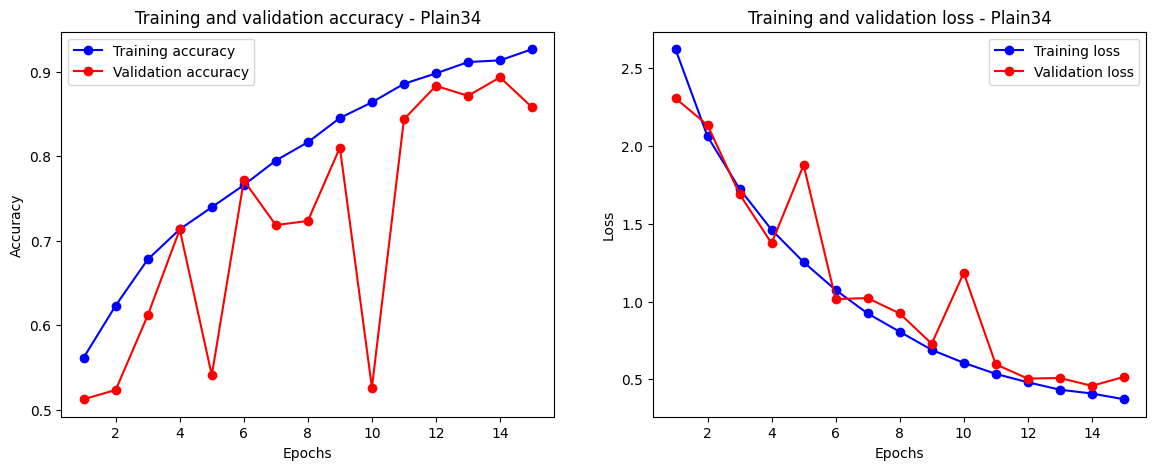

In [48]:
# Plain34 학습 히스토리 시각화하기
plot_history(history_plain_34, 'Plain34')

**왼쪽 그래프: 학습 및 검증 정확도**
* **파란색 선 (학습 정확도)** : 에포크가 진행됨에 따라 정확도가 꾸준히 증가하며, 15번째 에포크가 끝날 때쯤 0.9에 도달합니다.
* **빨간색 선 (검증 정확도)** : 초기에는 증가하지만, 상당한 변동을 보이며 눈에 띄는 하락과 상승이 반복되고, 15번째 에포크가 끝날 때쯤 약 0.8에 안정화됩니다.
오른쪽 그래프: 학습 및 검증 손실
* **파란색 선 (학습 손실)** : 에포크가 진행됨에 따라 손실이 꾸준히 감소하며, 15번째 에포크가 끝날 때쯤 매우 낮은 값에 도달합니다.
* **빨간색 선 (검증 손실)** : 또한 감소 추세를 보이지만, 상당한 변동이 있습니다. 초기에는 높게 시작하여 떨어지지만, 여러 지점에서 급격히 상승하는 불안정성을 보이며, 전체적으로는 감소하는 경향을 보입니다.

**해석**
* **학습 성능**
  * 학습 정확도는 꾸준히 증가하고 학습 손실은 지속적으로 감소하여 모델이 학습 데이터로부터 효과적으로 학습하고 있음을 나타냅니다.
* **검증 성능**
  * 검증 정확도와 손실은 상당한 변동을 보여, 검증 세트에서 성능이 일정하지 않음을 나타냅니다.
  * 최종 검증 정확도는 약 0.8로 안정화되며, 학습 정확도보다 낮아 과적합(overfitting)의 가능성을 시사합니다.
  * 검증 손실의 불안정한 패턴도 모델이 학습 데이터에 과적합하여 보이지 않는 데이터에 대해 일반화(generalization)하는 데 어려움을 겪고 있음을 나타냅니다.

**결론**
* Plain34 모델은 학습 세트에서는 좋은 학습 성능을 보여주지만, 검증 세트에서는 일반화에 어려움을 겪고 있습니다.

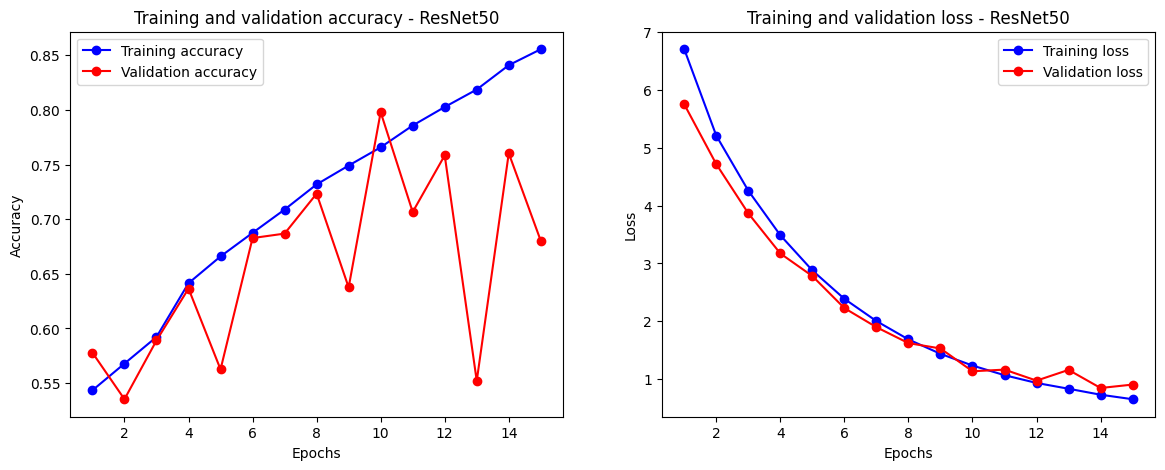

In [53]:
# ResNet50 학습 히스토리 시각화하기
plot_history(history_resnet_50, 'ResNet50')

**왼쪽 그래프: 학습 및 검증 정확도**
* **파란색 선 (학습 정확도)** : 에포크가 진행됨에 따라 정확도가 꾸준히 증가하며, 15번째 에포크가 끝날 때쯤 0.85에 도달합니다.
* **빨간색 선 (검증 정확도)** : 초기에는 증가하지만, 상당한 변동을 보이며 눈에 띄는 하락과 상승이 반복되고, 15번째 에포크가 끝날 때쯤 약 0.7에 안정화됩니다.

**오른쪽 그래프: 학습 및 검증 손실**
* **파란색 선 (학습 손실)** : 에포크가 진행됨에 따라 손실이 꾸준히 감소하며, 15번째 에포크가 끝날 때쯤 매우 낮은 값에 도달합니다.
* **빨간색 선 (검증 손실)** : 또한 감소 추세를 보이지만, 상당한 변동이 있습니다. 초기에는 높게 시작하여 떨어지지만, 여러 지점에서 급격히 상승하는 불안정성을 보이며, 전체적으로는 감소하는 경향을 보입니다.

**해석**
* **학습 성능**
  * 학습 정확도는 꾸준히 증가하고 학습 손실은 지속적으로 감소하여 모델이 학습 데이터로부터 효과적으로 학습하고 있음을 나타냅니다.
* **검증 성능**
  * 검증 정확도와 손실은 상당한 변동을 보여, 검증 세트에서 성능이 일정하지 않음을 나타냅니다.
  * 최종 검증 정확도는 약 0.7로 안정화되며, 학습 정확도보다 낮아 과적합(overfitting)의 가능성을 시사합니다.
  * 검증 손실의 불안정한 패턴도 모델이 학습 데이터에 과적합하여 보이지 않는 데이터에 대해 일반화(generalization)하는 데 어려움을 겪고 있음을 나타냅니다.

**결론**
* ResNet50 모델은 학습 세트에서는 좋은 학습 성능을 보여주지만, 검증 세트에서는 일반화에 어려움을 겪고 있습니다.

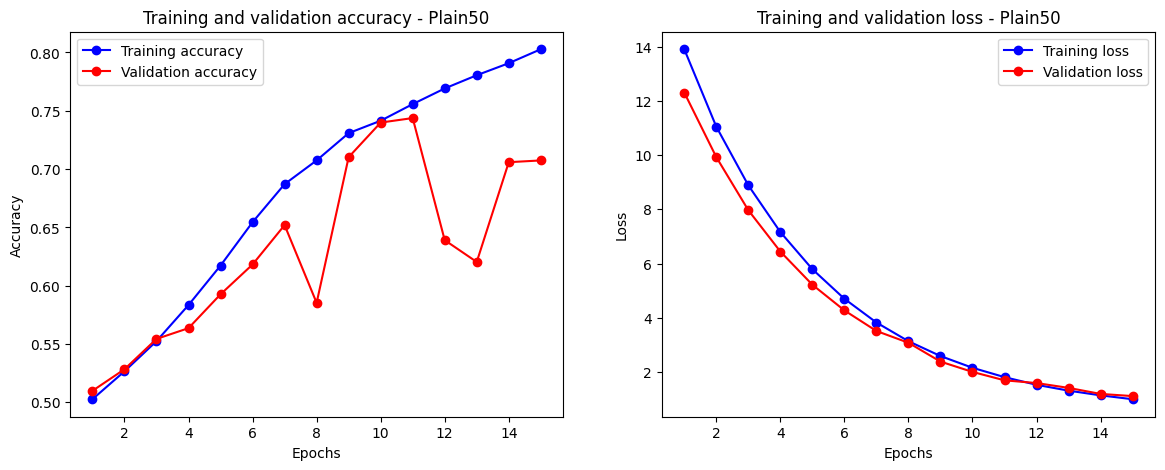

In [54]:
# Plain50 학습 히스토리 시각화하기
plot_history(history_plain_50, 'Plain50')

**왼쪽 그래프: 학습 및 검증 정확도**
* **파란색 선 (학습 정확도)** : 에포크가 진행됨에 따라 정확도가 꾸준히 증가하며, 15번째 에포크가 끝날 때쯤 0.8에 도달합니다.
* **빨간색 선 (검증 정확도)** : 초기에는 증가하지만, 상당한 변동을 보이며 눈에 띄는 하락과 상승이 반복되고, 15번째 에포크가 끝날 때쯤 약 0.7에 안정화됩니다.

**오른쪽 그래프: 학습 및 검증 손실**
* **파란색 선 (학습 손실)** : 에포크가 진행됨에 따라 손실이 꾸준히 감소하며, 15번째 에포크가 끝날 때쯤 매우 낮은 값에 도달합니다.
* **빨간색 선 (검증 손실)** : 또한 감소 추세를 보이지만, 상당한 변동이 있습니다. 초기에는 높게 시작하여 떨어지지만, 여러 지점에서 급격히 상승하는 불안정성을 보이며, 전체적으로는 감소하는 경향을 보입니다.

**해석**
* **학습 성능**
  * 학습 정확도는 꾸준히 증가하고 학습 손실은 지속적으로 감소하여 모델이 학습 데이터로부터 효과적으로 학습하고 있음을 나타냅니다.
* **검증 성능**
  * 검증 정확도와 손실은 상당한 변동을 보여, 검증 세트에서 성능이 일정하지 않음을 나타냅니다.
  * 최종 검증 정확도는 약 0.7로 안정화되며, 학습 정확도보다 낮아 과적합(overfitting)의 가능성을 시사합니다.
  * 검증 손실의 불안정한 패턴도 모델이 학습 데이터에 과적합하여 보이지 않는 데이터에 대해 일반화(generalization)하는 데 어려움을 겪고 있음을 나타냅니다.

**결론**
* Plain50 모델은 학습 세트에서는 좋은 학습 성능을 보여주지만, 검증 세트에서는 일반화에 어려움을 겪고 있습니다.

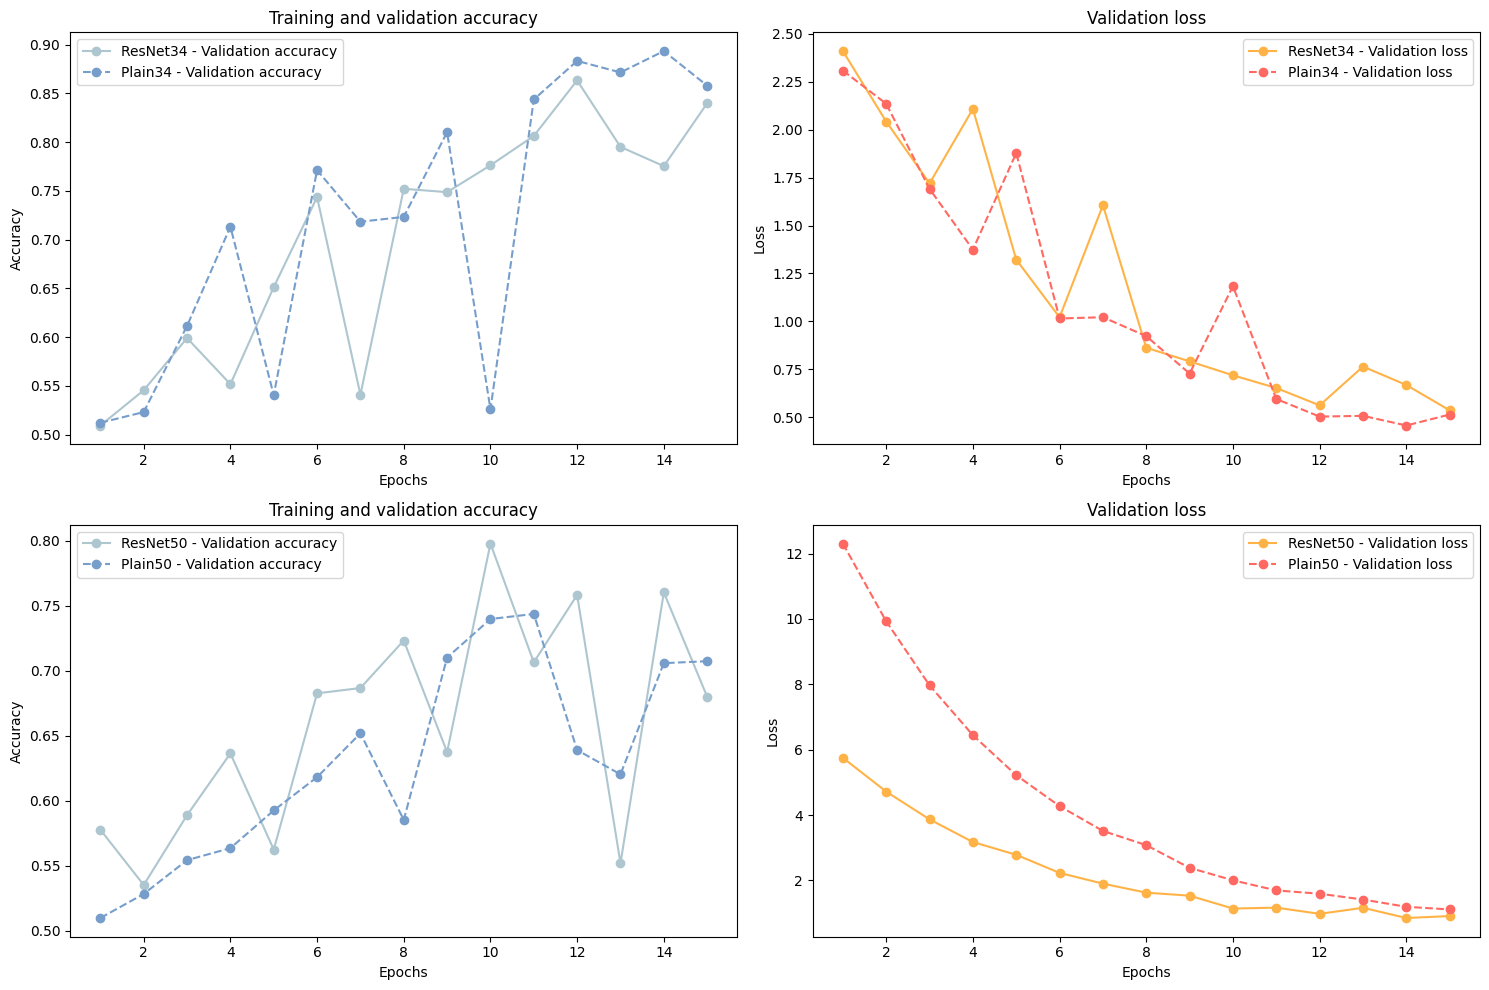

In [55]:
# ResNet34와 ResNet50 / Plain34와 Plain50 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

def plot_comparison(ax, history1, history2, title1, title2):
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']

    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    epochs = range(1, len(acc1) + 1)

    ax[0].plot(epochs, val_acc1, color='#AEC6CF', linestyle='-', marker='o', label=f'{title1} - Validation accuracy')
    ax[0].plot(epochs, val_acc2, color='#779ECB', linestyle='--', marker='o', label=f'{title2} - Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, val_loss1, color='#FFB347', linestyle='-', marker='o', label=f'{title1} - Validation loss')
    ax[1].plot(epochs, val_loss2, color='#FF6961', linestyle='--', marker='o', label=f'{title2} - Validation loss')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

# ResNet34 vs Plain34 비교 시각화하기
plot_comparison(axes[0], history_resnet_34, history_plain_34, 'ResNet34', 'Plain34')

# ResNet50 vs Plain50 비교 시각화하기
plot_comparison(axes[1], history_resnet_50, history_plain_50, 'ResNet50', 'Plain50')

plt.tight_layout()
plt.show()

**위쪽 그래프들: ResNet34 vs. Plain34**

**왼쪽 위 그래프: 학습 및 검증 정확도**
* **ResNet34 (파란색 실선)** : 검증 정확도는 초기에는 상승하지만 에포크가 진행됨에 따라 상당한 변동을 보이며 15번째 에포크가 끝날 때쯤 약 0.8에 도달합니다.
* **Plain34 (파란색 점선)** : 검증 정확도는 초기에는 상승하지만 더 큰 변동을 보이며 15번째 에포크가 끝날 때쯤 약 0.7에 도달합니다.

**오른쪽 위 그래프: 학습 및 검증 손실**
* **ResNet34 (주황색 실선)** : 검증 손실은 초기에는 급격히 감소하지만, 에포크가 진행됨에 따라 더 작은 변동을 보이며 15번째 에포크가 끝날 때쯤 비교적 낮은 값을 유지합니다.
* **Plain34 (주황색 점선)** : 검증 손실은 초기에는 급격히 감소하지만, 더 큰 변동을 보이며 15번째 에포크가 끝날 때쯤 비교적 높은 값을 유지합니다.
아래쪽 그래프들: ResNet50 vs. Plain50

**왼쪽 아래 그래프: 학습 및 검증 정확도**
* **ResNet50 (파란색 실선)** : 검증 정확도는 초기에는 상승하지만 에포크가 진행됨에 따라 변동을 보이며 15번째 에포크가 끝날 때쯤 약 0.75에 도달합니다.
* **Plain50 (파란색 점선)** : 검증 정확도는 초기에는 상승하지만 더 큰 변동을 보이며 15번째 에포크가 끝날 때쯤 약 0.7에 도달합니다.

**오른쪽 아래 그래프: 학습 및 검증 손실**
* **ResNet50 (주황색 실선)** : 검증 손실은 초기에는 급격히 감소하지만, 에포크가 진행됨에 따라 더 작은 변동을 보이며 15번째 에포크가 끝날 때쯤 비교적 낮은 값을 유지합니다.
* **Plain50 (주황색 점선)**: 검증 손실은 초기에는 급격히 감소하지만, 더 큰 변동을 보이며 15번째 에포크가 끝날 때쯤 비교적 높은 값을 유지합니다.

**종합 해석**
* **학습 및 검증 정확도**
  * ResNet34와 ResNet50 모델 모두 Plain34와 Plain50 모델보다 더 높은 검증 정확도를 보입니다.
  * ResNet 모델들은 상대적으로 더 안정된 성능을 보이며, Plain 모델들은 더 큰 변동성을 보입니다.

* **학습 및 검증 손실**
  * ResNet34와 ResNet50 모델 모두 Plain34와 Plain50 모델보다 더 낮은 검증 손실을 보입니다.
  * ResNet 모델들은 초기 에포크 동안 더 빠르게 손실이 감소하며, Plain 모델들은 더 큰 변동성을 보입니다.

* **결론**
* ResNet 모델 (ResNet34, ResNet50)이 Plain 모델 (Plain34, Plain50)보다 더 나은 검증 성능을 보입니다.
* Plain 모델들은 검증 성능에서 더 큰 변동성을 보여 과적합의 위험이 더 높아 보입니다.
* ResNet 모델을 사용하는 것이 더 안정적이고 일관된 성능을 보일 가능성이 높습니다.

## **2. 회고**

**[ 배운점 & 느낀점 ]** 2일 간의 여정으로 다양한 `backbone network`와 `ablation study`에 대해서 공부하게 되었는데, 다양한 논문과 작동 원리를 배울 수 있어서 좋았다. 이를 바탕으로 다양한 실험을 진행할 수 있을 것 같아 설레는 마음도 있다.

**[ 어려운 점 & 아쉬운 점 ]** 다만 블록을 쌓는 과정에서 어려움이 있었고, 오랜만에 colab에서 작업하게 되었는데, gpu 문제인지, 혹은 모델의 규모 문제인지는 모르겠는데, 이러한 이유로 퀘스트 시간에 완성하지 못했다는 것이 아쉬운 점으로 남는다.